# Standard imports

In [42]:
import pandas as pd
import os
import random
import time
import math
from keras.models import Sequential
from tensorflow.keras import utils, models
from tensorflow.keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from keras import layers
import numpy as np
import sklearn.preprocessing as prep
from sklearn.model_selection import train_test_split
import tensorflow as tf
import plotly.express as px
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import zipfile
random.seed(0)

# Data preprocessing

We first import all the data and read in as dataframes.

In [2]:
# upload csv files to google collab
drive.mount('/content/drive/')
!mkdir file_destination
!unzip "/content/drive/My Drive/stock_data" -d file_destination

Mounted at /content/drive/
Archive:  /content/drive/My Drive/stock_data.zip
   creating: file_destination/stock_data/
  inflating: file_destination/__MACOSX/._stock_data  
  inflating: file_destination/stock_data/CSCO.csv  
  inflating: file_destination/__MACOSX/stock_data/._CSCO.csv  
  inflating: file_destination/stock_data/UAL.csv  
  inflating: file_destination/__MACOSX/stock_data/._UAL.csv  
  inflating: file_destination/stock_data/GTLB.csv  
  inflating: file_destination/__MACOSX/stock_data/._GTLB.csv  
  inflating: file_destination/stock_data/PDD.csv  
  inflating: file_destination/__MACOSX/stock_data/._PDD.csv  
  inflating: file_destination/stock_data/PBR-A.csv  
  inflating: file_destination/__MACOSX/stock_data/._PBR-A.csv  
  inflating: file_destination/stock_data/DVN.csv  
  inflating: file_destination/__MACOSX/stock_data/._DVN.csv  
  inflating: file_destination/stock_data/NU.csv  
  inflating: file_destination/__MACOSX/stock_data/._NU.csv  
  inflating: file_destination/s

In [3]:
file_dir = "/content/file_destination/stock_data"
stock_data = [f for f in os.listdir(file_dir)]

In [19]:
# store dataframes in a list
# dfs = []
# for data in stock_data:
#     file_path = f"/content/file_destination/stock_data/{data}"
#     df = pd.read_csv(file_path, encoding='utf-8')
#     dfs.append(df)
df = pd.read_csv("AMZN.csv")

We need to preprocess the data with the following steps. First, filter down to columns we want. Second, split the data into dependent (y) and independent (X) variables. In our case, the close price is what we want to predict and the open, high, low prices are indicators we use for the prediction. Third, we shift the data by 1 so that we can use the information from today to predict the close price of tomorrow. Last, we split the datasets to train, validation, and test set.

In [20]:
def shift_data(X, y, time_step):
    """
    Shifts the input features (X) and target variable (y) based on the specified time step.

    Parameters:
    - X (pd.DataFrame): Input features DataFrame.
    - y (pd.Series): Target variable Series.
    - time_step (int): Number of time steps to shift the data.

    Returns:
    - pd.DataFrame, pd.Series: Shifted input features (X) and target variable (y).
    """
    X = X.iloc[:-time_step]
    y = y.iloc[time_step:]
    return X, y

def data_preprocessing1(df):
    """
    Perform data preprocessing on the given DataFrame.

    This function keeps only the necessary columns ('Open', 'High', 'Low', 'Close'),
    shifts the data by one time step, and performs a train-validation-test split.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing financial data.

    Returns:
    - X_train, X_val, X_test: Input features for training, validation, and testing sets.
    - y_train, y_val, y_test: Target variable for training, validation, and testing sets.
    """
    # keep necessary columns
    col_list = ["Open", "High", "Low", "Close"]
    df = df[col_list]

    X = df.drop(['Close'],axis = 1)
    y = df['Close']

    X, y = shift_data(X, y, 1)

    # train validation test split
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        shuffle=False)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [21]:
X_train, X_val, X_test, y_train, y_val, y_test = data_preprocessing1(df)
#df_orig = dfs[0].copy()

Here is an visualization of how the dataset is splited into train, validation, and test sets.

range(0, 1004) range(1004, 1205) range(1205, 1256)


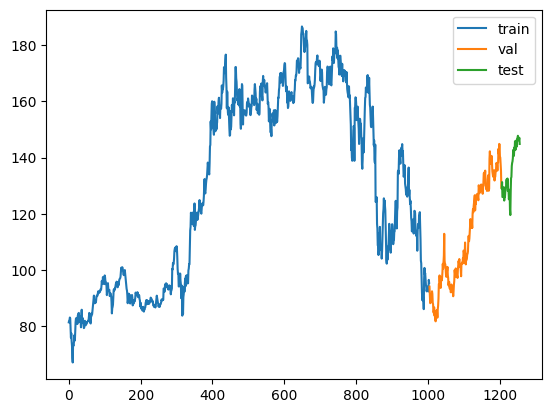

In [22]:
time_train = range(len(y_train))
time_val = range(len(y_train), len(y_train) + len(y_val))
time_test = range(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test))
print(time_train, time_val, time_test)

plt.plot(time_train, y_train, label='train')
plt.plot(time_val, y_val, label='val')
plt.plot(time_test, y_test, label='test')
plt.legend()

We have to reshape the data so that it can be used in LSTM model.

In [23]:
def reshape_X(X_train, X_test, X_val):
    """
    Reshape input feature sets for compatibility with LSTM.

    This function converts input DataFrames to NumPy arrays and reshapes them to have an
    additional dimension, usually required for input to neural networks with sequential data.

    Parameters:
    - X_train (pd.DataFrame): Input features for training set.
    - X_test (pd.DataFrame): Input features for testing set.
    - X_val (pd.DataFrame): Input features for validation set.

    Returns:
    X_train, X_test, X_val: Reshaped input feature arrays.
    """
    X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
    X_val = X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1)

    return X_train, X_test, X_val

# Model training

## Model 1 - baseline model

We construct the model with four layers: 1 LSTM layer and 3 dense layers.

In [24]:
model1 = tf.keras.models.Sequential([
  layers.LSTM(64, activation = 'relu', input_shape=(3, 1)),
  layers.Dense(32),
  layers.Dense(32),
  layers.Dense(1)
])

We also implement early stopping criterion to prevent overfitting.

In [25]:
model1.compile(optimizer = "adam",
               loss = "mean_squared_error",
               metrics=['mae', 'mse', 'mape'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model1.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = 100,
                    callbacks=[early_stopping],
                    shuffle = False)

Epoch 1/100
32/32 [==============================] - 3s 18ms/step - loss: 2572.0085 - mae: 42.1091 - mse: 2572.0085 - mape: 39.0478 - val_loss: 72.4840 - val_mae: 7.9184 - val_mse: 72.4840 - val_mape: 6.9611
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 83.2901 - mae: 7.9367 - mse: 83.2901 - mape: 6.6431 - val_loss: 8.3678 - val_mae: 2.2075 - val_mse: 8.3678 - val_mape: 1.9865
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 21.4378 - mae: 3.6248 - mse: 21.4378 - mape: 2.8711 - val_loss: 9.4149 - val_mae: 2.3772 - val_mse: 9.4149 - val_mape: 2.1203
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 15.2529 - mae: 2.9452 - mse: 15.2529 - mape: 2.3090 - val_loss: 10.0003 - val_mae: 2.4685 - val_mse: 10.0003 - val_mape: 2.1897
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 14.0982 - mae: 2.7866 - mse: 14.0982 - mape: 2.1678 - val_loss: 10.5757 - val_mae: 2.5563 - val_mse: 10.5757 - val_mape

Let's evaluate the model performance on the test set.

In [26]:
predict_test = model1.predict(X_test)
predict_test = np.roll(predict_test, -1)
df = pd.DataFrame({
    "Predicted": predict_test.ravel(),
    "real": y_test.ravel()
})
df.head()

2/2 [==============================] - 0s 6ms/step


,Predicted,real
0,129.015839,129.119995
1,128.514420,131.270004
2,127.035187,125.980003
3,124.441696,125.980003
4,123.260437,125.980003


<Axes: >

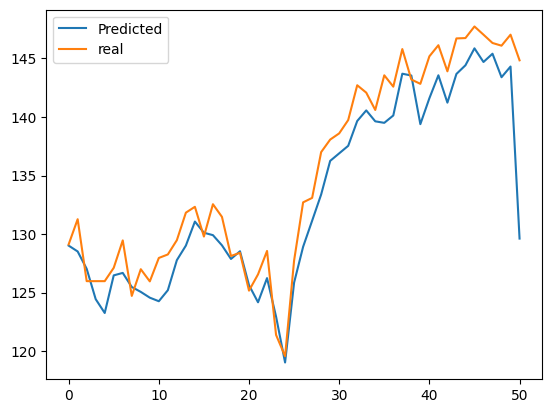

In [27]:
df.plot()

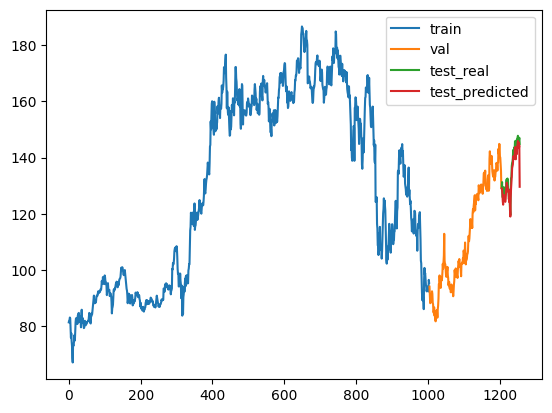

In [28]:
plt.plot(time_train, y_train, label='train')
plt.plot(time_val, y_val, label='val')
plt.plot(time_test, df["real"], label='test_real')
plt.plot(time_test, df["Predicted"], label='test_predicted')
plt.legend()

In [29]:
combined_data = np.concatenate([y_train, y_val, df["Predicted"]])

# create a DataFrame with a single column
df = pd.DataFrame({'combined_data': combined_data})

# export the DataFrame
df.to_csv('googl.csv', index=False)
from google.colab import files
files.download("googl.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
mae = history.history['mae']
mse = history.history['mse']
mape = history.history['mape']

# Create a DataFrame
metrics_df = pd.DataFrame({'MAE': mae, 'MSE': mse, 'MAPE': mape})
metrics_df.head(10)

,MAE,MSE,MAPE
0,42.109108,2572.008545,39.047848
1,7.936709,83.290138,6.643055
2,3.624781,21.437756,2.871109
3,2.945162,15.252899,2.309004
4,2.786576,14.098200,2.167782
5,2.820750,14.424967,2.185869
6,2.897369,14.895461,2.252657
7,2.919868,15.161030,2.264112
8,2.971601,15.543422,2.310915
9,2.922455,15.380480,2.259114


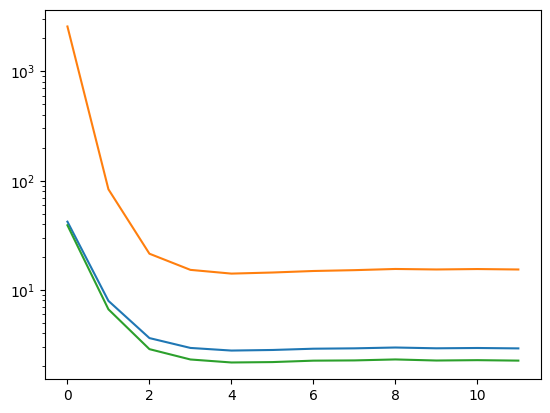

In [31]:
plt.plot(metrics_df)
plt.yscale("log")

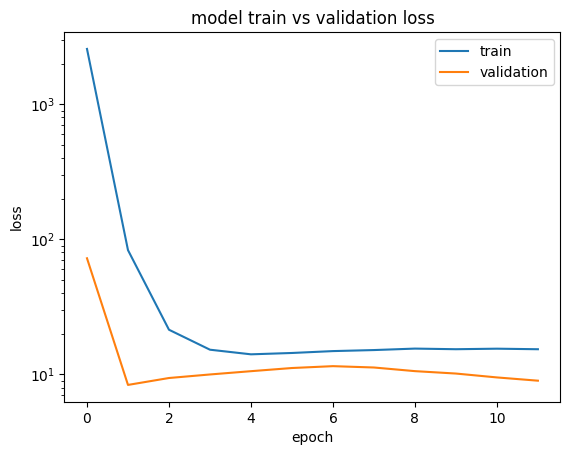

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.yscale("log")
plt.show()

## Model 2 - with macroeconomics data

In [33]:
# function that calculates moving average
def MA_calculation(ticker,MAs = [5,10,20,50,100,200,500]):
    """
    Create moving average columns of 'close'
    data column in our historical price dataset
    """
    ticker = ticker.copy()
    for ma in MAs:
        ticker[f'MA_{ma}'] = ticker['Close'].rolling(window=ma,min_periods=1).mean()
    return ticker

In [34]:
# function that calculates Moving average convergence divergence (MACD)
def MACD_calculation(ticker):
    ticker=ticker.copy()
    # Get the 26-day EMA of the closing price
    k = ticker['Close'].ewm(span=12, adjust=False, min_periods=1).mean()
    # Get the 12-day EMA of the closing price
    d = ticker['Close'].ewm(span=26, adjust=False, min_periods=1).mean()
    # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
    macd = k - d
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=9, adjust=False, min_periods=1).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    ticker['macd'] = ticker.index.map(macd)
    ticker['macd_h'] = ticker.index.map(macd_h)
    ticker['macd_s'] = ticker.index.map(macd_s)
    return ticker

In [35]:
# function that calculates Relative strength index (RSI)
def RSI_calculation(ticker, period = 14):

    close_delta = ticker['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    ma_up = up.ewm(com = period - 1, adjust=True, min_periods = 1).mean()
    ma_down = down.ewm(com = period - 1, adjust=True, min_periods = 1).mean()

    rsi = ma_up / (ma_down + 10e-8)
    ticker['RSI'] = 100 - (100/(1 + rsi))
    return ticker

In [36]:
def monthly_to_daily(df):
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
    df=df.set_index('DATE').resample('D').ffill()
    df = df.reset_index()
    df['DATE']=df['DATE'].dt.strftime('%Y-%m-%d')
    return df

In [38]:
# CBOE Volatility Index (Investor’s fear index)
VIX=pd.read_csv('^VIX.csv')
VIX=VIX[['Date','Close']]
VIX=VIX.rename(columns={"Close": "VIX"})
# Interest Rate
DFF=pd.read_csv('DFF.csv')
for i in range(len(DFF)):
  if DFF["EFFR"][i] == ".":
    DFF["EFFR"][i] = DFF["EFFR"][i-1]
# US dollar index
USDX=pd.read_csv('DX-Y.NYB.csv')
USDX=USDX[['Date','Close']]
USDX=USDX.rename(columns={"Close": "USDX"})
# Civilian unemployment rate
UNRATE=pd.read_csv('UNRATE.csv')
UNRATE=monthly_to_daily(UNRATE)
# Consumer sentiment index
UMCSENT=pd.read_csv('UMCSENT.csv')
UMCSENT=monthly_to_daily(UMCSENT)

In [39]:
# function that calculates Average true range (ATR)
def ATR_calculation(ticker, n_s=[14,20,22]):
    for n in n_s:
        ticker[f'ATR_{n}'] = pd.Series(np.amax(np.vstack(((ticker['High'] - ticker['Low']),
                                                          abs(ticker['High'] - ticker['Close']),
                                                          abs(ticker['Low'] - ticker['Close']))).T, axis=1))
    return ticker

In [40]:
def technical_macro_merge(ticker):
    ticker=MA_calculation(ticker,MAs = [5,10,20,50,100,200,500])
    ticker=MACD_calculation(ticker)
    ticker=ATR_calculation(ticker, n_s=[14,20,22])
    ticker=RSI_calculation(ticker,period=14)
    ticker=ticker.merge(VIX,how='left',on='Date')
    ticker=ticker.merge(DFF,how='left',left_on='Date',right_on='DATE')
    ticker=ticker.merge(USDX,how='left',on='Date')
    ticker=ticker.merge(UNRATE,how='left',left_on='Date',right_on='DATE')
    ticker=ticker.merge(UMCSENT,how='left',left_on='Date',right_on='DATE')
    ticker=ticker.drop(labels=['DATE_x','DATE_y','DATE'], axis=1)
    return ticker

In [70]:
df=technical_macro_merge(df)
df

,Date,Open,High,Low,Close,Adj Close,Volume,MA_5,MA_10,MA_20,...,VIX_x,EFFR_x,USDX_x,UNRATE_x,UMCSENT_x,VIX_y,EFFR_y,USDX_y,UNRATE_y,UMCSENT_y
0,2018-12-06,17.219999,17.520000,16.77,17.490000,12.416733,3471500,17.490000,17.490000,17.490000,...,21.190001,2.2,96.809998,3.9,98.3,21.190001,2.2,96.809998,3.9,98.3
1,2018-12-07,17.430000,17.430000,16.85,16.969999,12.047569,12131400,17.229999,17.229999,17.229999,...,23.230000,2.19,96.510002,3.9,98.3,23.230000,2.19,96.510002,3.9,98.3
2,2018-12-10,17.000000,17.080000,16.76,16.980000,12.054667,3058900,17.146666,17.146666,17.146666,...,22.639999,2.2,97.220001,3.9,98.3,22.639999,2.2,97.220001,3.9,98.3
3,2018-12-11,17.200001,17.299999,17.02,17.020000,12.083067,5065100,17.115000,17.115000,17.115000,...,21.760000,2.19,97.389999,3.9,98.3,21.760000,2.19,97.389999,3.9,98.3
4,2018-12-12,17.000000,17.100000,16.65,16.700001,12.032629,4222500,17.032000,17.032000,17.032000,...,21.459999,2.19,97.040001,3.9,98.3,21.459999,2.19,97.040001,3.9,98.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2023-11-28,4.770000,4.820000,4.68,4.760000,4.760000,8241100,4.668000,4.682000,4.735000,...,12.690000,5.33,102.750000,NaN,NaN,12.690000,5.33,102.750000,NaN,NaN
1253,2023-11-29,4.840000,5.090000,4.84,4.900000,4.900000,11608700,4.740000,4.704000,4.741000,...,12.980000,5.33,102.769997,NaN,NaN,12.980000,5.33,102.769997,NaN,NaN
1254,2023-11-30,4.930000,4.950000,4.78,4.850000,4.850000,12241500,4.800000,4.714000,4.750500,...,12.920000,5.33,103.500000,NaN,NaN,12.920000,5.33,103.500000,NaN,NaN
1255,2023-12-01,4.870000,5.210000,4.82,5.210000,5.210000,23356200,4.908000,4.776000,4.750500,...,12.630000,5.33,103.269997,NaN,NaN,12.630000,5.33,103.269997,NaN,NaN


In [71]:
def data_preprocessing(df):
    df = df.dropna()

    df = df.drop(['Date'],axis = 1)
    df_normalized = df.copy()
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    # Normalize the values in the copied DataFrame
    df_normalized[df.columns] = scaler.fit_transform(df[df.columns])
    print(df_normalized)
    # split dependent and independent varibles
    X = df_normalized.drop(['Close'],axis = 1)
    X = X.drop(['Adj Close'],axis = 1)

    # time series data adjustment so that we have X_t = y_t+1
    #X = X.iloc[:-1]
    #y = df_normalized['Close'].iloc[1:]
    y = df_normalized['Close']
    y = np.asarray(y).astype('float32')

    # split for train, test, validation
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        shuffle=False)

    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        shuffle=False)
    #reshape the data to input for LSTM model
    X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
    X_val = X_val.to_numpy().reshape(X_val.shape[0], X_val.shape[1], 1)

    return X_train, X_test, X_val, y_train, y_test, y_val

In [72]:
X_train, X_test, X_val, y_train, y_test, y_val = data_preprocessing(df)

          Open      High       Low     Close  Adj Close    Volume      MA_5  \
1     0.648168  0.641588  0.623622  0.624477   0.456309  0.178514  0.638165   
2     0.625654  0.623302  0.618898  0.625000   0.456771  0.031882  0.633750   
3     0.636126  0.634796  0.632546  0.627092   0.458618  0.064306  0.632072   
4     0.625654  0.624347  0.613123  0.610356   0.455338  0.050688  0.627675   
5     0.613613  0.621212  0.619423  0.622908   0.466582  0.033616  0.621848   
...        ...       ...       ...       ...        ...       ...       ...   
1207  0.010995  0.010972  0.008399  0.013075   0.016256  0.215800  0.019284   
1208  0.007853  0.004702  0.001050  0.000523   0.000650  0.255436  0.008900   
1209  0.000524  0.000000  0.000000  0.000000   0.000000  0.234042  0.000848   
1210  0.000000  0.006792  0.003675  0.010460   0.013005  0.195636  0.000000   
1211  0.008377  0.019854  0.012073  0.021967   0.027310  0.216949  0.001166   

         MA_10     MA_20     MA_50  ...     VIX_x  

In [75]:
model2 = tf.keras.models.Sequential([
  layers.LSTM(256, activation = 'relu', input_shape=(28, 1)),
  #layers.Dropout(0.2),
  # layers.Dense(128),
  # layers.Dropout(0.2),
  layers.Dense(64),
  layers.Dense(32),
  layers.Dense(16),
  layers.Dense(1)
])

In [76]:
model2.compile(optimizer = "adam",
               loss = "mean_squared_error",
               metrics=['mae', 'mse', 'mape'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model2.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs = 100,
                    batch_size = 8,
                    callbacks=[early_stopping],
                    shuffle = False)

Epoch 1/100
121/121 [==============================] - 5s 20ms/step - loss: 0.0217 - mae: 0.0943 - mse: 0.0217 - mape: 14.1913 - val_loss: 0.0468 - val_mae: 0.1927 - val_mse: 0.0468 - val_mape: 95.5960
Epoch 2/100
121/121 [==============================] - 2s 17ms/step - loss: 0.0168 - mae: 0.1009 - mse: 0.0168 - mape: 14.7884 - val_loss: 0.0481 - val_mae: 0.1962 - val_mse: 0.0481 - val_mape: 97.1057
Epoch 3/100
121/121 [==============================] - 2s 16ms/step - loss: 0.0168 - mae: 0.1066 - mse: 0.0168 - mape: 15.6203 - val_loss: 0.0599 - val_mae: 0.2244 - val_mse: 0.0599 - val_mape: 108.8588
Epoch 4/100
121/121 [==============================] - 3s 22ms/step - loss: 0.0171 - mae: 0.1054 - mse: 0.0171 - mape: 15.7008 - val_loss: 0.0772 - val_mae: 0.2602 - val_mse: 0.0772 - val_mape: 123.7938
Epoch 5/100
121/121 [==============================] - 3s 27ms/step - loss: 0.0175 - mae: 0.1054 - mse: 0.0175 - mape: 15.8650 - val_loss: 0.0945 - val_mae: 0.2915 - val_mse: 0.0945 - val_ma

In [77]:
predict_test = model2.predict(X_test)
#predict_test = np.roll(predict_test, -1)
predict_test = predict_test.reshape(49,)
amz = pd.DataFrame({
    "Predicted": predict_test,
    "real": y_test
})
amz.head()

2/2 [==============================] - 0s 13ms/step


,Predicted,real
0,0.396549,0.283996
1,0.396884,0.280858
2,0.396816,0.292364
3,0.396050,0.272490
4,0.397242,0.262552


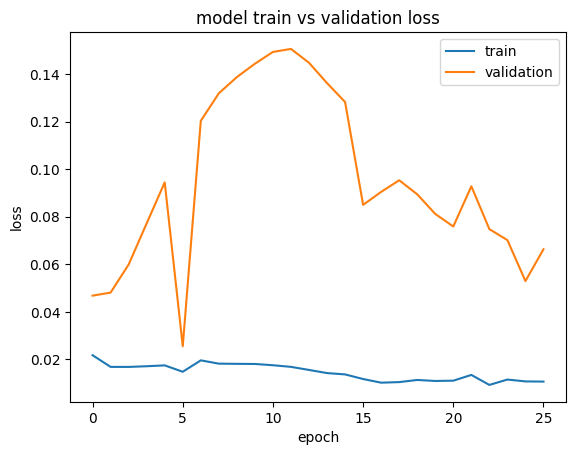

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
#plt.yscale("log")
plt.show()